In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import model_zoo
import data_freiburg_numpy_to_hdf5


## Using model

In [4]:
# load saved model
loss = "dice"
out_channels = 2
in_channels = 1
cut_z = 3
da = 0.0
model_path = f'/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_{da}nchannels{in_channels}_r_phase_{loss}_cut_z_{cut_z}'
#model_path = f'/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_{da}nchannels{in_channels}_r_phase_dice_cut_z_5_debug'
#model_path = "/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_0.0nchannels1_r_DEBUG_LOSS_phase_dice_cut_z_0"
best_model_path = os.path.join(model_path, list(filter(lambda x: 'best' in x, os.listdir(model_path)))[-1])
print(best_model_path)
model = model_zoo.UNet(in_channels, out_channels);
model.load_state_dict(torch.load(best_model_path, map_location=torch.device('cpu')));
model.eval();

/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_0.0nchannels1_r_phase_dice_cut_z_3/model_best_38_step_2500.pth


In [5]:
project_data_root = '/usr/bmicnas02/data-biwi-01/jeremy_students/previous_work/nicolas/data/freiburg'
data_vl = data_freiburg_numpy_to_hdf5.load_data(basepath = project_data_root,

                                                        idx_start = 20,
                                                        idx_end = 24,
                                                        train_test='validation')
images_vl = data_vl['images_validation']
labels_vl = data_vl['labels_validation']        

Already preprocessed this configuration. Loading now...


In [6]:

data_tr = data_freiburg_numpy_to_hdf5.load_data(basepath = project_data_root,
                                                    idx_start = 0,
                                                    idx_end = 19,
                                                    train_test='train')
images_tr = data_tr['images_train']
labels_tr = data_tr['labels_train']
images_vl.shape, labels_vl.shape

Already preprocessed this configuration. Loading now...


((160, 144, 112, 48, 4), (160, 144, 112, 48))

In [7]:
# Here you should do the cutting... 
def cut_z_slices(images, labels, n_cut):
    n_data = images.shape[0]
    index = np.arange(n_data)
    # We know we have 32 slices
    # First dim is the number of patients
    index_shaped = index.reshape(-1, 32)
    index_keep = index_shaped[:, n_cut:-n_cut].flatten()
    return images[index_keep], labels[index_keep]

In [106]:
if cut_z != 0:
    images_tr, labels_tr = cut_z_slices(images_tr, labels_tr, n_cut = cut_z)
    images_vl, labels_vl = cut_z_slices(images_vl, labels_vl, n_cut = cut_z)

In [1]:
images_vl.shape, labels_vl.shape

NameError: name 'images_vl' is not defined

In [ ]:
batch_size = 8
np.random.seed(0)
inputs = images_tr[np.sort(np.random.randint(len(images_tr), size = batch_size))]
np.random.seed(0)
labels = labels_tr[np.sort(np.random.randint(len(images_vl), size = batch_size))]

inputs = torch.from_numpy(inputs)
# Input (batch_size, channell,x,y,z)
inputs.transpose_(1,4).transpose_(2,4).transpose_(3,4)
labels = torch.from_numpy(labels)

In [ ]:
inputs.shape, labels.shape

(torch.Size([8, 4, 144, 112, 48]), torch.Size([8, 144, 112, 48]))

In [30]:
pred = model(inputs)

In [31]:
import torch.nn.functional as F
prediction = F.softmax(pred, dim=1).argmax(dim = 1)

In [32]:
%matplotlib inline
def plot_time(t = 0):
    fig, axs = plt.subplots(4,4);
    img = 0
    for i, ax in enumerate(axs.reshape(-1)):
        
        if i%2 == 0:
            ax.imshow(prediction[img,:,:,t].detach().numpy())
            

        else:
            ax.imshow(labels[img,:,:,t].detach().numpy())   
            img = img + 1 
    fig.show()

/tmp/ipykernel_30497/3488933913.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


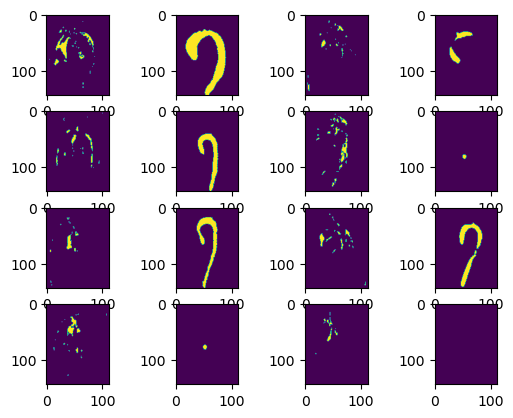

In [35]:
plot_time(27)

## Visualization the outputs


In [8]:
viz_on = "validation" # training/validation
model_path

'/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_0.0nchannels1_r_phase_dice_cut_z_3'

In [13]:
best_model_path

'/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_0.0nchannels1_r_phase_dice_cut_z_3/model_best_38_step_2500.pth'

In [9]:
list_files_train = os.listdir(model_path + f'/results/visualization/{viz_on}/')
image_number_train = 10
list_files_train[:8]

['step_0_pred_image_0.npy',
 'step_0_true_image_0.npy',
 'step_0_input_image_0.npy',
 'step_0_pred_image_10.npy',
 'step_0_true_image_10.npy',
 'step_0_input_image_10.npy',
 'step_400_pred_image_0.npy',
 'step_400_true_image_0.npy']

In [10]:
image_filter_train = list(filter(lambda x: f'_image_{image_number_train}' in x, list_files_train))
image_filter_train[-5:]

['step_9200_true_image_10.npy',
 'step_9200_input_image_10.npy',
 'step_9600_pred_image_10.npy',
 'step_9600_true_image_10.npy',
 'step_9600_input_image_10.npy']

In [17]:
image_filter_train

['step_0_pred_image_10.npy',
 'step_0_true_image_10.npy',
 'step_0_input_image_10.npy',
 'step_400_pred_image_10.npy',
 'step_400_true_image_10.npy',
 'step_400_input_image_10.npy',
 'step_800_pred_image_10.npy',
 'step_800_true_image_10.npy',
 'step_800_input_image_10.npy',
 'step_1200_pred_image_10.npy',
 'step_1200_true_image_10.npy',
 'step_1200_input_image_10.npy',
 'step_1600_pred_image_10.npy',
 'step_1600_true_image_10.npy',
 'step_1600_input_image_10.npy',
 'step_2000_pred_image_10.npy',
 'step_2000_true_image_10.npy',
 'step_2000_input_image_10.npy',
 'step_2400_pred_image_10.npy',
 'step_2400_true_image_10.npy',
 'step_2400_input_image_10.npy',
 'step_2800_pred_image_10.npy',
 'step_2800_true_image_10.npy',
 'step_2800_input_image_10.npy',
 'step_3200_pred_image_10.npy',
 'step_3200_true_image_10.npy',
 'step_3200_input_image_10.npy',
 'step_3600_pred_image_10.npy',
 'step_3600_true_image_10.npy',
 'step_3600_input_image_10.npy',
 'step_4000_pred_image_10.npy',
 'step_4000_t

In [18]:
step = 2400
pred = np.load(os.path.join(model_path,f'results/visualization/{viz_on}', list(filter(lambda x: f'_{step}' in x, image_filter_train))[0]))
gt = np.load(os.path.join(model_path,f'results/visualization/{viz_on}', list(filter(lambda x: f'_{step}' in x, image_filter_train))[1]))
input = np.load(os.path.join(model_path,f'results/visualization/{viz_on}', list(filter(lambda x: f'_{step}' in x, image_filter_train))[2]))
np.where(gt ==1), np.where(pred ==1)


((array([0, 0, 0, ..., 7, 7, 7]),
  array([46, 46, 46, ..., 59, 59, 59]),
  array([40, 40, 40, ..., 36, 36, 36]),
  array([ 0, 35, 36, ..., 18, 19, 30])),
 (array([0, 0, 0, ..., 7, 7, 7]),
  array([  7,   7,   7, ..., 140, 140, 140]),
  array([42, 43, 43, ..., 51, 51, 51]),
  array([25, 25, 26, ..., 19, 20, 21])))

In [19]:
def plot_batches(array, input_image = False):
    time_slice = 20
    if input_image:
        fig, axs = plt.subplots(2, 4, figsize=(10,10))
        for n, ax in enumerate(axs.reshape(-1)):
            ax.imshow(array[n,1,:,:,time_slice])
        plt.show()
    else:
        fig, axs = plt.subplots(2, 4, figsize=(10,10))
        for n, ax in enumerate(axs.reshape(-1)):
            ax.imshow(array[n,:,:,time_slice])
        plt.show()

In [20]:
plot_batches(pred)

/tmp/ipykernel_1563/1652297046.py:12: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [21]:
plot_batches(input, input_image = True)

IndexError: index 1 is out of bounds for axis 1 with size 1

In [22]:
plot_batches(gt)

/tmp/ipykernel_1563/1652297046.py:12: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [23]:
gt.shape, input.shape, pred.shape


((8, 144, 112, 48), (8, 1, 144, 112, 48), (8, 144, 112, 48))

In [41]:
%matplotlib inline
def presentation_viz(input, gt, pred, time, save_path, n_channels = 4, batch = 8):
    if n_channels == 4:
        h = 15
    else:
        h = 7
    
    fig, axs = plt.subplots(2+n_channels, batch, figsize = (15,h))
    nbatch = 0
    n_chan = n_channels
    ax = axs.reshape(-1)
    axes_index = 0
    for chan in range(n_channels):
        
        for i in range(batch):
            
            ax[axes_index].imshow(input[i, n_channels - n_chan, :, :, time])
            ax[axes_index].set_title(f"batch_{i}_chan_{n_channels - n_chan}_t_{time}", fontsize = 10)
            axes_index += 1
        n_chan -= 1
    for i in range(batch):
        ax[axes_index].imshow(pred[i, :,:, time])
        ax[axes_index].set_title(f"batch_{i}_pred_t_{time}", fontsize = 10)
        axes_index +=1
    for i in range(batch):
        ax[axes_index].imshow(gt[i, :,:, time])
        ax[axes_index].set_title(f"batch_{i}_gt_t_{time}", fontsize = 10)
        axes_index +=1
    plt.savefig(os.path.join(save_path, f"random_batch_t_{time}.png"), bbox_inches='tight')
    plt.show()
    
        

In [42]:
save_viz = model_path + f"/results/visualization/notebook_viz/{viz_on}"

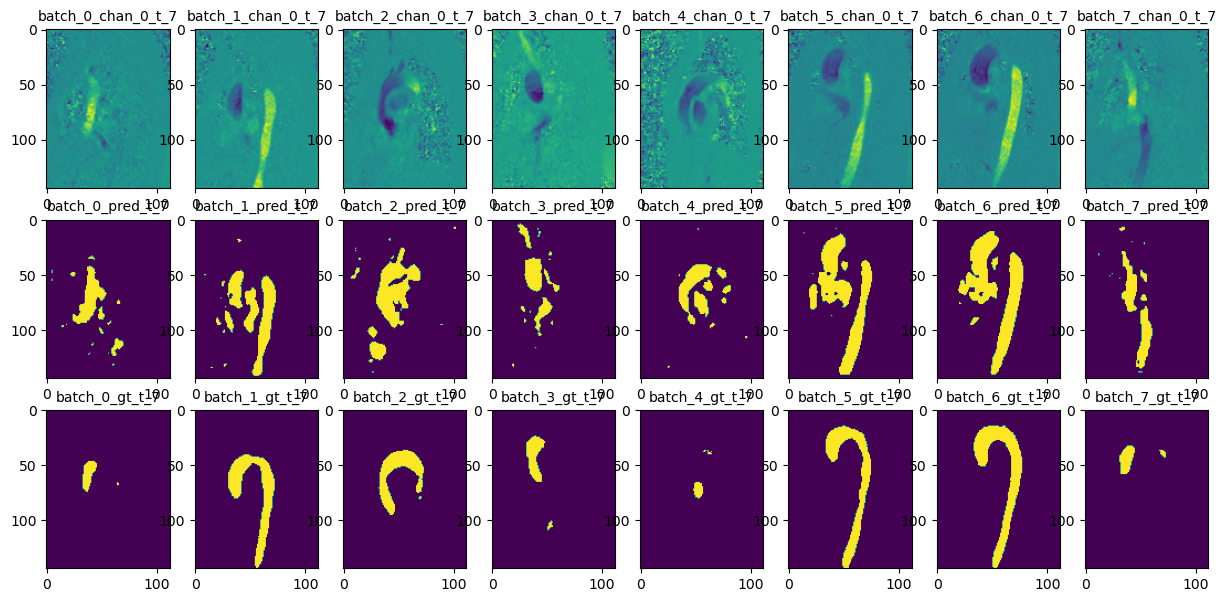

In [44]:
presentation_viz(input, gt, pred, time = 7, save_path= save_viz, n_channels = 1)

## Visualizing the inputs


In [315]:
debug_in = np.load(model_path + "/inputs_train_batch.npy")
debug_label = np.load(model_path + "/labels_train_batch.npy")

In [316]:
slice_ = 0

In [325]:
#slice_ = 0
print(slice_)
%matplotlib inline
plt.imshow(debug_in[slice_, :,:, 3,1])
plt.show()
plt.imshow(debug_in[slice_, :,:, 3,0])
plt.imshow(debug_label[slice_, :,:, 3], alpha= 0.1)
slice_ +=1 
plt.show()

8


IndexError: index 8 is out of bounds for axis 0 with size 8